In [1]:
# General imports
import numpy as np

# torch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from IPython.display import display
from skimage import io, transform

from tqdm.notebook import tqdm

# Computer Vision Lab Project WS 2023

## Description and Tasks:
The goal is to train a neural network that takes the Focal Stack images generated by the AOS script and reconstructs a restorated GT (ground truth) picture. 
The team can decide to use either a single Focal Stack Image or multiple.


So the tasks are: 
1. find good focal planes
2. remove unwanted noise in the picture and restore the ground truth.


## Questions of the appointment on 9.11.2023
Are any other models and pretrained weights allowed? 
-> Yes its allowed. 

How could we find good different focal planes? 
* maybe calculate some average image differences based on some criteria and choose pictures having a large criteria offset.

In [2]:
# Gerneral Tasks:

#TODO: decide upon focal stack. -> Is there maybe a analytical solution to this problem? 
# Somehow i have the feeling that the answer to this could lie in the lecture.
#TODO: Think about a general structure for the final project code, how to define and efficiently divide the tasks.

# General Open Tasks:
#TODO: Data cleaning and preprocessing
#TODO: Data preprocessing using AOS (idea: make a pytorch preprocessor that would allow to do a hyperparameter search.)
#TODO: Define model
#TODO: Implement Learning functions
#TODO: Define and code the General Pipeline

#TODO: create a function that logs the current learning process, saves the intermediate model, logs the learning process, eg.: train and test error. 
#TODO: create a global log file that keeps track of the best model. 
#TODO: create a function that logs the best model.

# Further Tasks:

#TODO: Hyperparameter Search:
## TODO: Focal Stack size
## TODO: Focal Stack step size
## TODO: Network type
## TODO: Network size

# Presentation:
#TODO: qualitative and quantitative evaluations are supposed to be drawn in the PPT.
#TODO: Pipeline and block diagram are supposed to be drawn
#TODO: Each member should present once.
#TODO: Presentation should be 6 mins. 

# Project report output
#TODO: include hyperparameters, focal stack, 
#TODO: environment.yml

# Global Parameters

Useage: 
* Save the dataset in ../dataset/Part?" where ? is the number of the dataset. 

Choose the Scenario: 

<ol>
    <li> Scenario = 1 only uses one picture at the input of the network at the focal plane of 0m.</li>
    <li> Scenario = 2 uses multiple pictures with different focal planes as the input of the network.</li>
</ol>

In [3]:
G_SCENARIO = 1 
G_DATSET_MAX_SIZE = 10 # for speed we reduce the dataset size, enter None for all data.

# use small test set in the beginning to validate that the code is working.
G_TRAIN_SET_RATIO = 0.8 
G_TEST_SET_RATIO = 1-G_TRAIN_SET_RATIO
assert (G_TEST_SET_RATIO + G_TRAIN_SET_RATIO) <= 1.0, 'Test and Train set split invalid'

# choose data sets to include in processing
G_DATASETS = {1: True,
              2: True,
              3: False}

# choose data set locations
G_DATASETS_LOCATION = {1: "../dataset/Part1",
                       2: "../dataset/Part2",
                       3: "../dataset/Part3"}

G_DATASET_LOCATION = [G_DATASETS_LOCATION[dataset_id] for dataset_id, include_dataset in G_DATASETS.items() if include_dataset]
#####################################
# Training settings
G_BATCH_SIZE = 128
G_LEARNING_RATE = 0.001

# Data Exploration and Cleaning
ensure that all data is availaible, only complete sets should be used. 


In [4]:
class RawDataset(Dataset):
    def __init__(self, folders, 
                 transform=None, 
                 target_transform=transforms.Compose([transforms.ToTensor()]),
                 relative_path=True,
                 maximum_datasize=None):
        
        
        if maximum_datasize is not None:
            if maximum_datasize <= 0:
                assert False, "Dataset cannnot be empty or negative"
        current_directory = os.getcwd()
        self.folders = []
        for folder in folders:
            if relative_path:
                # Construct the full path
                folder_path = os.path.join(os.getcwd(), folder)
            self.folders.append(folder_path)
            
        self.maximum_datasize = maximum_datasize
        self.transform = transform
        self.target_transform = target_transform
        self.data = self.load_data()

    def load_data(self):
        done = False
        data = []
        for folder in self.folders:
            files = os.listdir(folder)
            # Find all unique X numbers
            x_numbers = set()
            for filename in files:
                if filename.endswith(".png"):
                    parts = filename.split('_')
                    if len(parts) >= 2 and parts[1].isdigit():
                        x_numbers.add(int(parts[1]))

            x_numbers = sorted(x_numbers)                

            # Organize data into dictionaries
            for x_number in x_numbers:
                label_filename = os.path.join(folder, f"0_{x_number}_GT_pose_0_thermal.png")
                label_filename_rel = f"0_{x_number}_GT_pose_0_thermal.png"
                #training_data = [f"0_{x_number}_pose_{i}_thermal.png" for i in range(11)]
                training_data_rel = [f"0_{x_number}_pose_{i}_thermal.png" for i in range(11)]
                training_data = [os.path.join(folder, f"0_{x_number}_pose_{i}_thermal.png") for i in range(11)]
        
                # Check if both label and all training data files exist
                if label_filename_rel in files and all(training_file in files for training_file in training_data_rel):
                    data.append({
                        'label': label_filename,
                        'training_data': training_data
                    })
                    
                if len(data) == self.maximum_datasize:
                    done = True
                    break
            if done:
                break
                
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Fetching the file information from the data
        data_dict = self.data[idx] # dict!
        feature_filenames = data_dict['training_data']
        label_filename = data_dict['label']
    
        # Loading images and labels dynamically
        labels = io.imread(label_filename)
        #labels = labels[np.newaxis, ...] # add an axis in front such that it behaves like a multichannel picture having only one channel. 

        features = np.zeros((labels.shape[0], labels.shape[1], len(feature_filenames)))
        for i, file in enumerate(feature_filenames):
            features[:,:,i] = io.imread(os.path.join(file))
            
        if self.transform:
            features = np.array(features, dtype=np.float32)
            features = self.transform(features)

            
        if self.target_transform:
            labels = np.array(labels, dtype=np.float32)
            labels = self.target_transform(labels)
            

            
        return features, labels

In [5]:
def data_to_image(*data: torch.Tensor, 
                  means: tuple = (0, ), stds: tuple = (1., )) -> Image:
    """
    Convert multiple tensors to one big image.
    
    Parameters
    ----------
    data0, data1, ... dataN : torch.Tensor
        One or more tensors to be merged into a single image.
    means : tuple or torch.Tensor, optional
        Original mean of the image before normalisation.
    stds : tuple or torch.Tensor, optional
        Original standard deviation of the image before normalisation.

    Returns
    -------
    image : Image
        PIL image with all of the tensors next to each other.
    """
    # concatenate all data
    big_pic = torch.cat([x for x in data], dim=-1)
    
    means = torch.tensor(means)
    stds = torch.tensor(stds)
    to_image = transforms.Compose([
        # inverts normalisation of image
        #transforms.Normalize(-means / stds, 1. / stds),
        #transforms.Lambda(lambda x: torch.clamp(x, 0, 1)),
        transforms.ToPILImage()
    ])
    
    return to_image(big_pic)

In [6]:
def plot_images(label_image, feature_images):
    from torchvision.transforms.functional import to_pil_image
    """
    Plot the label image and 11 feature images side by side.

    Parameters:
    - label_image: PyTorch tensor representing the label image (batch_size, channels, height, width)
    - feature_images: List of 11 PyTorch tensors representing the feature images (batch_size, channels, height, width)
    """
    batches, feature_channels, x_size, y_size = feature_images.shape
    _, label_channels, _,_ = label_image.shape
    
    n_images_to_show =  feature_channels+label_channels
    b=0
    # paste together
    # features
    feature_images = feature_images.detach().cpu()
    xs = feature_images[b].view(-1, 1, x_size, y_size)  # unflatten
    x_im = data_to_image(*xs)
    
    # labels
    label = label_image.detach().cpu()
    xl = label[b,0].view(-1, 1, x_size, y_size)  # unflatten
    x_re = data_to_image(*xl)
    
    im = Image.new('L', (n_images_to_show * x_size, y_size))
    im.paste(x_im, (y_size, 0))
    im.paste(x_re, (0, 0))
    display(im, metadata={'width': '100%'})

Lets load the data and visualize the first image 
On the left we see the label image and on the right we see the feature images.

In [7]:
# Example usage:
folders = G_DATASET_LOCATION
transform = transforms.Compose([transforms.ToTensor()])

dataset = RawDataset(folders, transform=transform, maximum_datasize=10)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

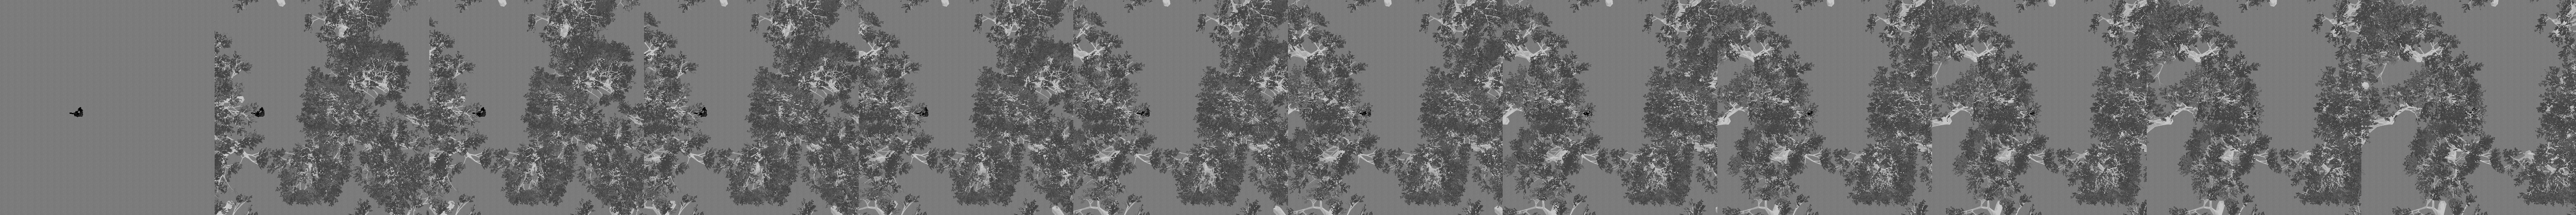

In [8]:
features, labels = next(iter(dataloader))
plot_images(labels, features)

# Data loading and splitting

In [9]:
# load the dataset
dataset = RawDataset(folders, transform=transform, maximum_datasize=G_DATSET_MAX_SIZE)

# Calculate the lengths of the training and testing sets
train_size = int(G_TRAIN_SET_RATIO * len(dataset))
test_size = len(dataset) - train_size

# Use random_split to split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=G_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=G_BATCH_SIZE, shuffle=True)

In [10]:
print(f"The dataset has exactly {len(dataset)} entries")
print(f"The train_dataset has {len(train_dataset)} entries")
print(f"The test dataset has {len(test_dataset)}")
print(f"The train set ratio is {len(train_dataset)/len(dataset)}")
print(f"The test set ratio is {len(test_dataset)/len(dataset)}")

The dataset has exactly 10 entries
The train_dataset has 8 entries
The test dataset has 2
The train set ratio is 0.8
The test set ratio is 0.2


# Preprocessing of Raw Pictures

* eg normalizations etc..

# Generate AOS pictures
If we implement the AOS as an pytorch preprocesser than we actually could do an hyperparametersearch over the focal lenghts. 
Other idea: are there maybe analytical solutions to usefull seperation of the focal distances? 

# Define Model

In [11]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Input channels: 11, Output channels: 64, Kernel size: 3x3, Padding: 1
        self.conv1 = nn.Conv2d(in_channels=11, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()

        # Additional convolutional layers can be added if needed
        # ...

        # Output layer
        # Input channels: 64, Output channels: 1, Kernel size: 3x3, Padding: 1
        self.conv_out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        # Additional layers can be added if needed
        # ...
        x = self.conv_out(x)

        return x

# Instantiate the CNN
model = CustomCNN()

# Print the architecture
print(model)

CustomCNN(
  (conv1): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv_out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# Learn the Model

In [12]:
def train(model, train_loader, num_epochs, 
          criterion = None,  
          optimizer = None, 
          learning_rate=0.001, 
          plot_progress=True,
          device='cpu'):
    
    print('#'*40)
    if optimizer is None:
        test = True
        print(f'# Testing the Model for {num_epochs} epochs #')
    else:
        print(f'# Training the Model for {num_epochs} epochs #')

    # Set the device
    model.to(device)
    
    # Define the loss function and the optimizer
    if criterion is None: 
        criterion = nn.MSELoss()
        
    losses = []
    
    # Training loop
    epoch = 0
    tqdm_epocs = tqdm(range(num_epochs))
    for epoch in tqdm_epocs:
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            losses.append(loss.detach().cpu())
            tqdm_epocs.set_postfix({f"Epoch {epoch + 1}/{num_epochs} | Loss": loss.item()}, refresh=True)
            
            
    return losses

In [13]:
optimizer = optim.Adam(model.parameters(), lr=G_LEARNING_RATE)
train_loss = train(model, train_loader, 10, optimizer=optimizer)
test_loss = train(model, test_loader, 10) # no optimzer -> behaves as test 

########################################
# Training the Model for 10 epochs #


  0%|          | 0/10 [00:00<?, ?it/s]

########################################
# Testing the Model for 10 epochs #


  0%|          | 0/10 [00:00<?, ?it/s]

# Make visualizations of the outputs

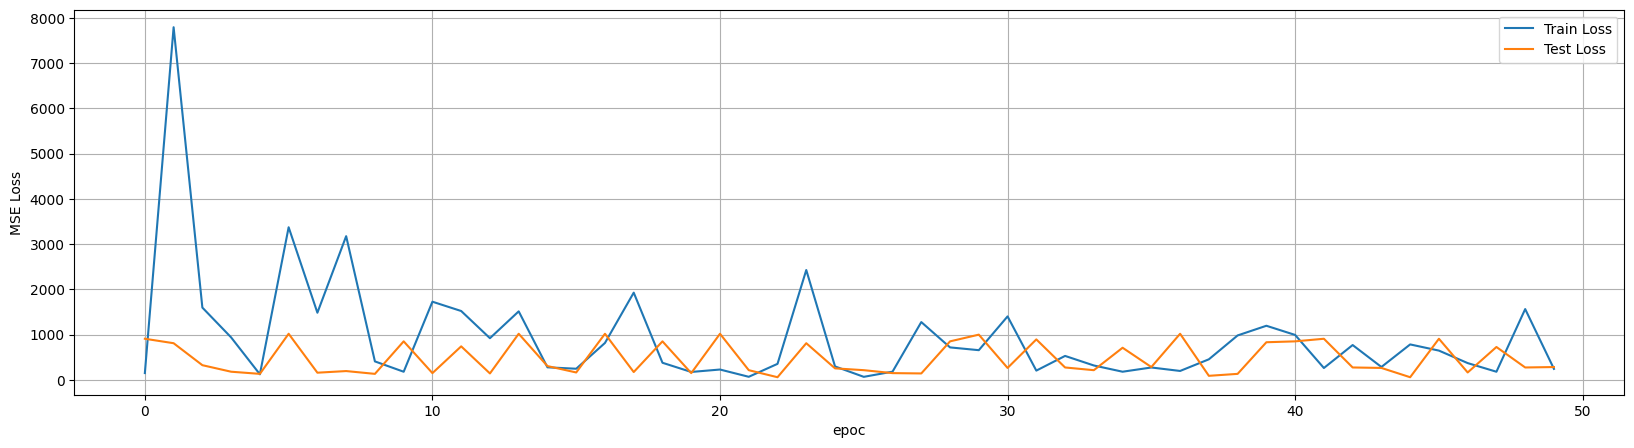

In [14]:
plt.figure(figsize=(20,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.ylabel("MSE Loss")
plt.xlabel("epoc")
plt.grid(True)
plt.legend()
plt.show()

Predict and compare some of the test images:

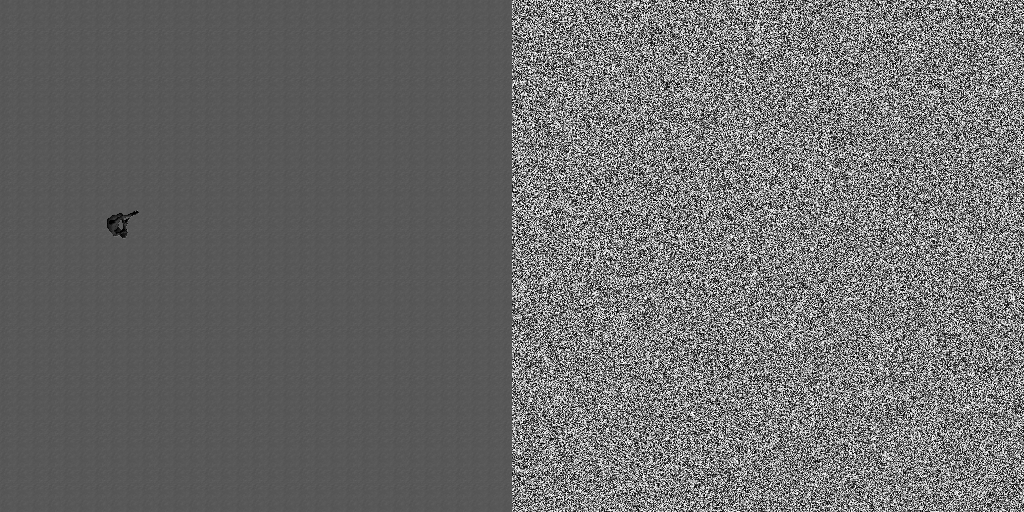

In [15]:
feature, label = next(iter(test_loader))
prediction = model(feature)
plot_images(label, prediction)